In [1]:
!pip install -qq einops

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

# see great explanation kernel: https://www.kaggle.com/code/awsaf49/gcvit-global-context-vision-transformer

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
image_size = 224
drop_rate = 0.2
batch_size = 64
EPOCHS = 30

In [5]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.5)],p=0.2),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.LongestMaxSize(max_size=image_size),
                      A.PadIfNeeded(min_height=image_size, min_width=image_size),
                      # A.Resize(height=image_size, width=image_size, p=1),
                      A.Cutout(num_holes=6, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# only resize, scale [-1, 1] and converting to tensor array[h,w,c] -> tensor[c,h,w]
valid_transforms = A.Compose([
                      A.LongestMaxSize(max_size=image_size),
                      A.PadIfNeeded(min_height=image_size, min_width=image_size),
                      # A.Resize(height=image_size, width=image_size, p=1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# inverse trasformations of a single image-tensor
def inverse_transforms(tensor):
    tensor = tensor 
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    tensor = torch.clamp(tensor * 0.5 + 0.5, min=0., max=1.)
    tensor = tensor.cpu().detach().numpy().transpose(1,2,0)

    return tensor

In [6]:
directory = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"

data = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data["labels"] = data.iloc[:, 1:].idxmax(axis=1)
data = data[~data["image"].str.contains("downsampled")]

classes_to_int = {v: i for i, v in enumerate(data.columns[1:-1])}
int_to_classes = {i: v for i, v in enumerate(data.columns[1:-1])}

data["labels"] = data["labels"].map(classes_to_int)

num_classes = len(classes_to_int)

x_train, x_test = train_test_split(data, test_size=1600, stratify=data["labels"], random_state=seed)
x_valid, x_test = train_test_split(x_test, test_size=400, stratify=x_test["labels"], random_state=seed)

x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

print(f"train size: {len(x_train)}, valid size: {len(x_valid)}, test size: {len(x_test)}")

train size: 21657, valid size: 1200, test size: 400


### Total Architecture

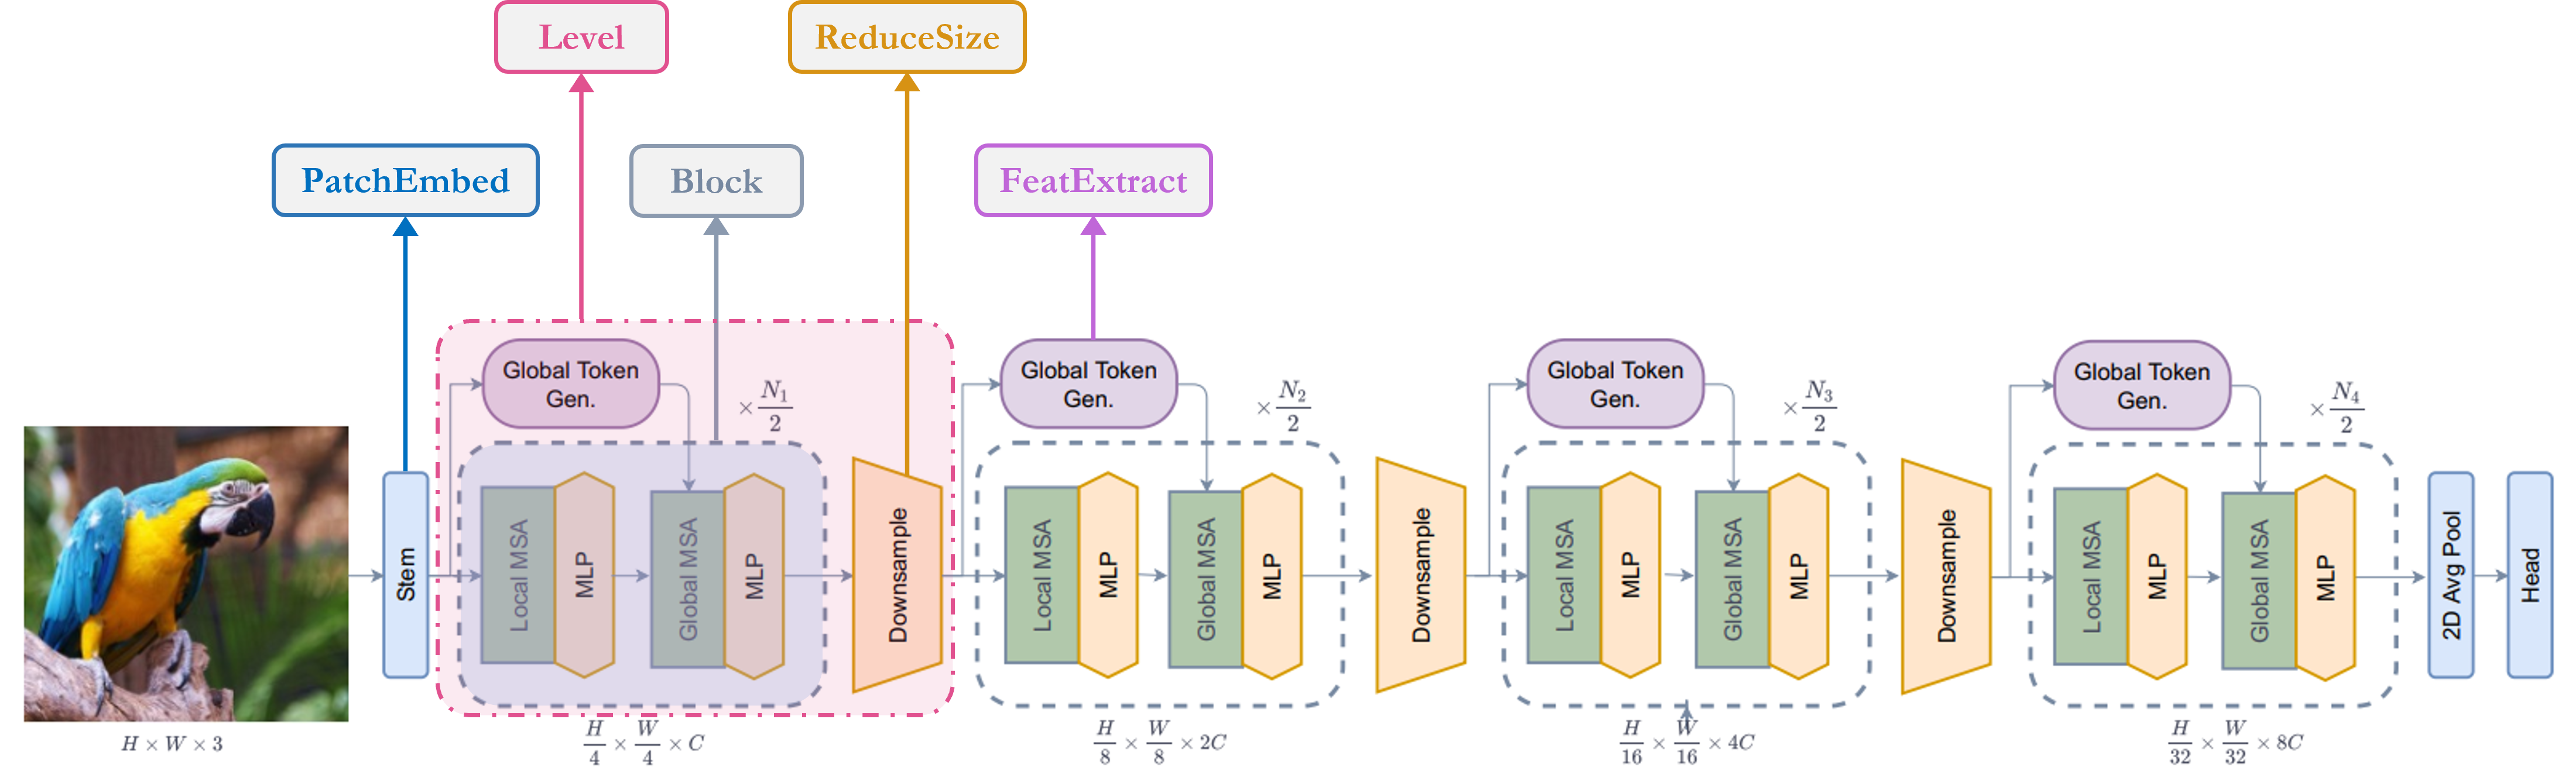

### Squeeze Excitation (channel attention)

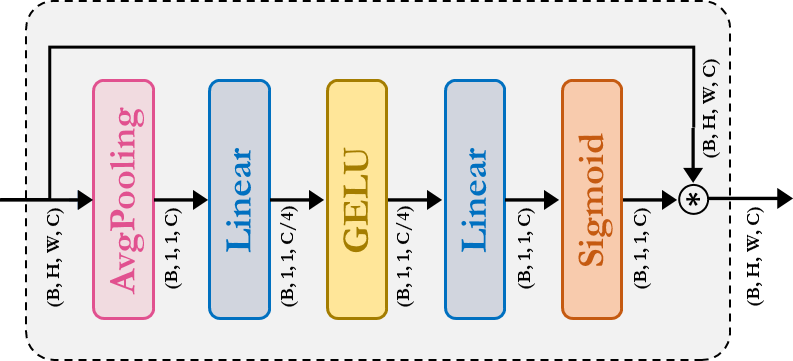

### Local (inside window) attention and gloabal attention with Q obtained outside window

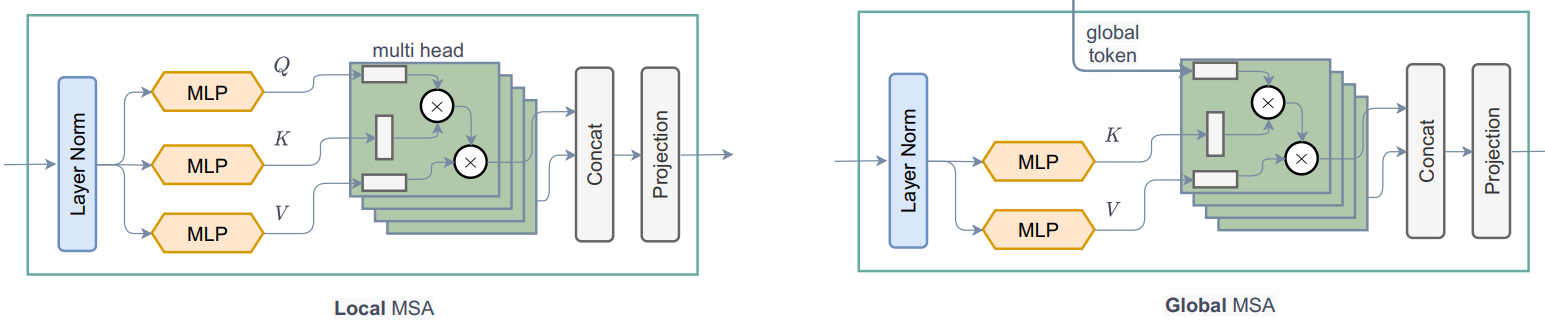

### Global (Q) token generation

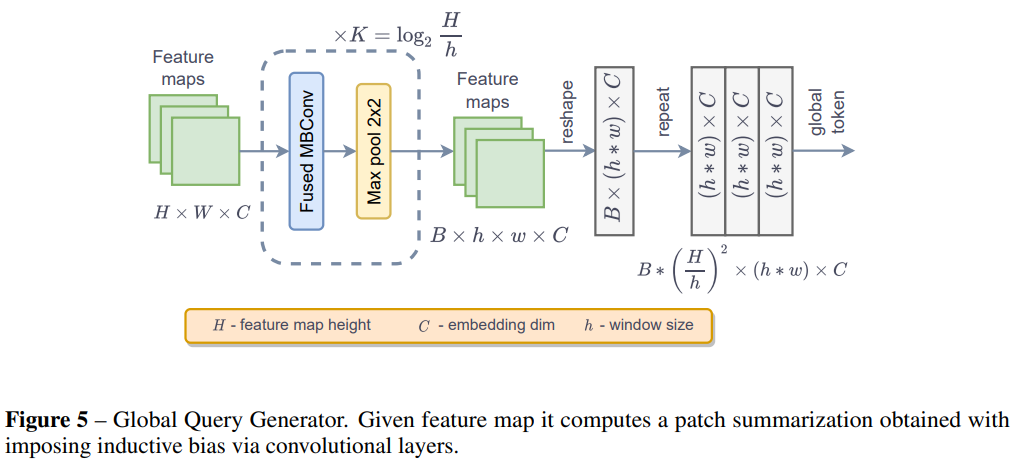

In [7]:
# like in original repo: define helper functions (window patching forward and backward, rearrangement of channel dim to apply Layernorm correctly)
# https://github.com/NVlabs/GCVit/blob/main/models/gc_vit.py

def channels_last(x):
    x = rearrange(x, "b c h w -> b h w c")
    return x

def channels_first(x):
    x = rearrange(x, "b h w c -> b c h w")
    return x

def window_patching(x, window_size, h_win, w_win):
    b, h, w, c = x.size()
    windows = rearrange(x, "b (hw hws) (ww wws) c -> (b hw ww) hws wws c", hw=h_win, ww=w_win, hws=window_size, wws=window_size)
    
    return windows

def reverse_window_patching(windows, window_size, h, w, h_w, w_w):
    batch_size = int(windows.size(0) / (h * w / window_size**2))
    x = rearrange(windows, "(b hw ww) (hws wws) c -> b (hw hws) (ww wws) c", b=batch_size, hw=h_w, ww=w_w, hws=window_size, wws=window_size)
    return x

In [8]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, activation=None, dropout=0.1):
        super(MLP, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.activation = F.gelu if activation is None else activation
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        return x
    
class Squeezer(nn.Module):
    def __init__(self, mode="forward"):
        super(Squeezer, self).__init__()
        self.mode = mode
        
    def forward(self, x, ):
        if self.mode == "forward":
            return x.squeeze()
        return x[..., None, None]
    
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, *args, expansion_rate=0.25, **kwargs):
        super(SqueezeExcitationBlock, self).__init__(*args, **kwargs)
        
        self.squeeze_excitation = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1),
                    Squeezer(mode="forward"),
                    nn.Linear(out_channels, int(in_channels * expansion_rate), bias=False),
                    nn.GELU(),
                    nn.Linear(int(in_channels * expansion_rate), out_channels, bias=False),
                    nn.Sigmoid(),
                    Squeezer(mode="backward"),
            )
    
    def forward(self, x):
        return x * self.squeeze_excitation(x)

In [9]:
class DownBlock(nn.Module):
    def __init__(self, dim, norm_layer=None, keep_dim=False):
        super(DownBlock, self).__init__()
        norm_layer = nn.LayerNorm if norm_layer is None else norm_layer
        
        self.conv = nn.Sequential(  
                nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim, bias=False),  # depthwise convolution
                nn.GELU(),
                SqueezeExcitationBlock(dim, dim),
                nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, bias=False),
            )
        
        dim_out = dim if keep_dim else 2 * dim

        self.reduction = nn.Conv2d(dim, dim_out, kernel_size=3, stride=2, padding=1, bias=False)  # reduce spatial dimensions by 2 times
        self.norm2 = norm_layer(dim_out)
        self.norm1 = norm_layer(dim)

    def forward(self, x):
        x = self.norm1(x)
        
        x = channels_first(x)
        x = x + self.conv(x)
        x = self.reduction(x)
        
        x = channels_last(x)
        x = self.norm2(x)
        
        return x
    
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, dim=96):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Conv2d(in_channels, dim, kernel_size=3, stride=2, padding=1)
        self.conv_down = DownBlock(dim=dim, keep_dim=True)

    def forward(self, x):
        x = self.projection(x)
        x = channels_last(x)
        x = self.conv_down(x)
        return x
    
class FeatureExtraction(nn.Module):
    def __init__(self, dim, keep_dim=False):
        super(FeatureExtraction, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim, bias=False),  # depthwise convolution
                nn.GELU(),
                SqueezeExcitationBlock(dim, dim),
                nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, bias=False),
            )
        if not keep_dim:
            self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # overlapping: kernel_size != stride
        self.keep_dim = keep_dim

    def forward(self, x):
        x = x + self.conv(x)
        if not self.keep_dim:
            x = self.pool(x)
        return x

In [10]:
# local window attention and global window attention taken from original repo as is

class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size, qkv_bias=True, qk_scale=None, attn_dropout=0.1, projection_dropout=0.1):
        super(WindowAttention, self).__init__()
        
        window_size = (window_size, window_size)
        self.window_size = window_size
        
        self.num_heads = num_heads
        self.head_dim = torch.div(dim, num_heads, rounding_mode='floor')  # each attention head dimension size
        
        self.scale = qk_scale or self.head_dim ** -0.5
        
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))
        
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, start_dim=1)  # [2, ws*ws]
        
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(dim=-1)  # indices of relative (neighboring) window positions
        
        self.register_buffer("relative_position_index", relative_position_index)
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.projection = nn.Linear(dim, dim)
        self.projection_dropout = nn.Dropout(projection_dropout)
        
        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, q_global):
        b, n, c = x.size()
        
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        
        attn = attn + relative_position_bias.unsqueeze(0)
        attn = self.softmax(attn)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        
        x = self.projection(x)
        x = self.projection_dropout(x)
        
        return x

In [11]:
class WindowAttentionGlobal(nn.Module):
    def __init__(self, dim, num_heads, window_size, qkv_bias=True, qk_scale=None, attn_dropout=0.1, projection_dropout=0.1):
        super(WindowAttentionGlobal, self).__init__()
        
        window_size = (window_size, window_size)
        self.window_size = window_size
        
        self.num_heads = num_heads
        self.head_dim = torch.div(dim, num_heads, rounding_mode='floor')
        self.scale = qk_scale or self.head_dim ** -0.5
        
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))
        
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, start_dim=1)
        
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(dim=-1)
        
        self.register_buffer("relative_position_index", relative_position_index)
        
        self.qkv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.projection = nn.Linear(dim, dim)
        self.projection_dropout = nn.Dropout(projection_dropout)
        
        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, q_global):
        b, n, c = x.size()
        bg = q_global.size(0)
        
        bg_dim = torch.div(b, bg, rounding_mode='floor')
        
        kv = self.qkv(x).reshape(b, n, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        
        q_global = q_global.repeat(1, bg_dim, 1, 1, 1)
        q = q_global.reshape(b, self.num_heads, n, self.head_dim)
        q = q * self.scale
        
        attn = (q @ k.transpose(-2, -1))
        
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        
        attn = attn + relative_position_bias.unsqueeze(0)
        attn = self.softmax(attn)
        attn = self.attn_dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.projection(x)
        x = self.projection_dropout(x)
        return x

In [12]:
class GCViTBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads,
                 window_size=7,
                 mlp_ratio=4.0,
                 qkv_bias=True,
                 qk_scale=None,
                 dropout=0.1,
                 attn_dropout=0.1,
                 dropout_path=0.1,
                 activation=None,
                 attention=None,
                 norm_layer=nn.LayerNorm,
                 layer_scale=None, ):

        super(GCViTBlock, self).__init__()
        attention = WindowAttentionGlobal if attention is None else attention
        activation = F.gelu if activation is None else activation
        norm_layer = nn.LayerNorm if norm_layer is None else norm_layer
        self.dropout_path = dropout_path
        
        self.window_size = window_size
        self.norm1 = norm_layer(dim)

        self.attn = attention(dim,
                              num_heads=num_heads,
                              window_size=window_size,
                              qkv_bias=qkv_bias,
                              qk_scale=qk_scale,
                              attn_dropout=attn_dropout,
                              projection_dropout=dropout,
                              )

        self.norm2 = norm_layer(dim)  
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), activation=activation, dropout=dropout)
        
        self.layer_scale = False
        if layer_scale is not None and type(layer_scale) in [int, float]:  # learnable scaling parameters (gamma1, gamma2)
            self.layer_scale = True
            self.gamma1 = nn.Parameter(layer_scale * torch.ones(dim), requires_grad=True)
            self.gamma2 = nn.Parameter(layer_scale * torch.ones(dim), requires_grad=True)
        else:
            self.gamma1 = 1.0
            self.gamma2 = 1.0

        inp_windows = torch.div(input_resolution, window_size, rounding_mode='floor')
        self.num_windows = int(inp_windows ** 2)
        
    def _drop_connections(self, x):
        if not self.training:
            return x
        keep_probability = 1.0 - self.dropout_path
        batch_size = x.size(0)
        random_tensor = keep_probability + torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_probability) * binary_tensor

    def forward(self, x, q_global):
        b, h, w, c = x.size()
        shortcut = x
        
        x = self.norm1(x)
        h_w = torch.div(h, self.window_size, rounding_mode='floor')
        w_w = torch.div(w, self.window_size, rounding_mode='floor')

        x_windows = window_patching(x, self.window_size, h_w, w_w)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, c)
        
        attn_windows = self.attn(x_windows, q_global)
        
        x = reverse_window_patching(attn_windows, self.window_size, h, w, h_w, w_w)
        
        x = shortcut + self._drop_connections(self.gamma1 * x)  # torchvision.ops.stochastic_depth(input=self.gamma1*x, p=self.dropout_path, mode="batch", training=self.training)
        x = x + self._drop_connections(self.gamma2 * self.mlp(self.norm2(x)))
        
        return x

In [13]:
class GlobalQueryGenerator(nn.Module):
    def __init__(self, dim, input_resolution, image_resolution, window_size, num_heads):
        super(GlobalQueryGenerator, self).__init__()
        
        if input_resolution == image_resolution // 4:
            self.to_q_global = nn.Sequential(
                        FeatureExtraction(dim, keep_dim=False),
                        FeatureExtraction(dim, keep_dim=False),
                        FeatureExtraction(dim, keep_dim=False),
                )

        elif input_resolution == image_resolution // 8:
            self.to_q_global = nn.Sequential(
                        FeatureExtraction(dim, keep_dim=False),
                        FeatureExtraction(dim, keep_dim=False),
                )

        elif input_resolution == image_resolution // 16:
            if window_size == input_resolution:
                self.to_q_global = nn.Sequential(
                            FeatureExtraction(dim, keep_dim=True)
                    )
            else:
                self.to_q_global = nn.Sequential(
                            FeatureExtraction(dim, keep_dim=False)
                    )

        elif input_resolution == image_resolution // 32:
            self.to_q_global = nn.Sequential(
                        FeatureExtraction(dim, keep_dim=True)
                )

        self.resolution = input_resolution
        self.num_heads = num_heads
        self.n_wins = window_size * window_size
        self.dim_head = torch.div(dim, self.num_heads, rounding_mode='floor')

    def forward(self, x):
        x = channels_last(self.to_q_global(x))
        b = x.size(0)
        x = x.reshape(b, 1, self.n_wins, self.num_heads, self.dim_head).permute(0, 1, 3, 2, 4)
        
        return x

In [14]:
class GCViTLayer(nn.Module):
    def __init__(self, dim, depth, input_resolution, image_resolution, num_heads, window_size,
                 downsample=True,
                 mlp_ratio=4.0,
                 qkv_bias=True,
                 qk_scale=None,
                 dropout=0.1,
                 attn_dropout=0.1,
                 dropout_path=0.1,
                 norm_layer=None,
                 layer_scale=None):

        super(GCViTLayer, self).__init__()
        norm_layer = nn.LayerNorm if norm_layer is None else norm_layer
        
        self.blocks = nn.ModuleList([
                    GCViTBlock(dim=dim,
                               num_heads=num_heads,
                               window_size=window_size,
                               mlp_ratio=mlp_ratio,
                               qkv_bias=qkv_bias,
                               qk_scale=qk_scale,
                               attention=WindowAttention if (i % 2 == 0) else WindowAttentionGlobal,
                               dropout=dropout,
                               attn_dropout=attn_dropout,
                               dropout_path=dropout_path[i] if isinstance(dropout_path, list) else dropout_path,
                               norm_layer=norm_layer,
                               layer_scale=layer_scale,
                               input_resolution=input_resolution)
                    for i in range(depth)])
        self.downsample = None if not downsample else DownBlock(dim=dim, norm_layer=norm_layer)
        self.q_global_gen = GlobalQueryGenerator(dim, input_resolution, image_resolution, window_size, num_heads)

    def forward(self, x):
        q_global = self.q_global_gen(channels_first(x))
        for block in self.blocks:
            x = block(x, q_global)
            
        if self.downsample is None:
            return x
        return self.downsample(x)

In [15]:
class GCViT(nn.Module):
    def __init__(self, dim, depths, window_size, mlp_ratio, num_heads,
                 resolution=224,
                 dropout_path_rate=0.2,
                 in_channels=3,
                 num_classes=10,
                 qkv_bias=True,
                 qk_scale=None,
                 dropout_rate=0.1,
                 attn_dropout_rate=0.1,
                 norm_layer=nn.LayerNorm,
                 layer_scale=None,
                 **kwargs):

        super(GCViT, self).__init__(**kwargs)

        num_features = int(dim * 2 ** (len(depths) - 1))
        self.num_classes = num_classes
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, dim=dim)
        
        self.pos_dropout = nn.Dropout(p=dropout_rate)
        dpr = [x.item() for x in torch.linspace(0, dropout_path_rate, sum(depths))]
        
        self.levels = nn.ModuleList()
        for i in range(len(depths)):
            level = GCViTLayer(dim=int(dim * 2 ** i),
                               depth=depths[i],
                               num_heads=num_heads[i],
                               window_size=window_size[i],
                               mlp_ratio=mlp_ratio,
                               qkv_bias=qkv_bias,
                               qk_scale=qk_scale,
                               dropout=dropout_rate, 
                               attn_dropout=attn_dropout_rate,
                               dropout_path=dpr[sum(depths[:i]):sum(depths[:i + 1])],
                               norm_layer=norm_layer,
                               downsample=(i < len(depths) - 1),
                               layer_scale=layer_scale,
                               input_resolution=int(2 ** (-2 - i) * resolution),
                               image_resolution=resolution)
            self.levels.append(level)
            
        self.norm = norm_layer(num_features)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.head = nn.Linear(num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.patch_embedding(x)
        x = self.pos_dropout(x)

        for level in self.levels:
            x = level(x)

        x = self.norm(x)
        x = channels_first(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [16]:
class ISICDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(directory + row["image"] + ".jpg")
        image = np.array(image)
        
        sample = {"image": image}
        image = self.transforms(**sample)["image"]
        
        label = torch.as_tensor(row["labels"], dtype=torch.int64)
        
        return image, label
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        images, labels = [[tensor[None] for tensor in subset] for subset in (images, labels)]
        images, labels = [torch.cat(subset, dim=0).to(device) for subset in (images, labels)]
        return images, labels

In [17]:
train_ds = ISICDataset(x_train, train_transforms)
valid_ds = ISICDataset(x_valid, valid_transforms)
test_ds = ISICDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=test_ds.collate_fn)

In [18]:
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

def train_one_batch(data, model, criterion, optimizer):
    model.train()
    images, labels = data
    
    optimizer.zero_grad()
    out = model(images)
    loss = criterion(out, labels)
    
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(out, labels).item()
    
    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    images, labels = data
    
    out = model(images)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [19]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None, **kwargs):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {'model': GCViT(**kwargs),
                          'state_dict': model.state_dict(),
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [20]:
params = {
    "depths": [3, 4, 19, 5],  # [2, 2, 6, 2]
    "num_heads": [2, 4, 8, 16],
    "window_size": [7, 7, 14, 7],
    "dim": 64,
    "mlp_ratio": 3,
    "dropout_path_rate": 0.2,
    "resolution": image_size,
}

model = GCViT(**params).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=EPOCHS//3, eta_min=1e-8)

stopper = EarlyStopping(patience=6)

print(f" Number of training parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

 Number of training parameters: 27714104


In [ ]:
print_freq = 20

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
        
    stopper(np.mean(valid_loss), model, **params)
    # scheduler.step(np.mean(valid_loss))
    scheduler.step()
    
test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dl)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)))

In [ ]:
def load_checkpoint(filepath="model.pth", device="cuda"):
    checkpoint = torch.load(filepath, map_location=device)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint()

In [22]:
@torch.no_grad()
def plot(num_images, model):
    model.eval()
    indices = np.random.choice(np.arange(len(test_ds)), size=num_images)
    num_cols = 3
    num_rows = int(np.ceil(num_images / num_cols))
    
    plt.figure(figsize=(num_rows * 3, num_cols*3))
    for j, i in enumerate(indices, 1):
        image, label = test_ds[i]
        out = model(image.unsqueeze(0).to(device))
        y_pred = int_to_classes.get(torch.max(out, 1)[1][0].item(), "error")
        label = int_to_classes.get(label.item(), "error")
        
        image = inverse_transforms(image)
        plt.subplot(num_rows, num_cols, j)
        plt.imshow(image)
        plt.title(f"True label: {label}, pred: {y_pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

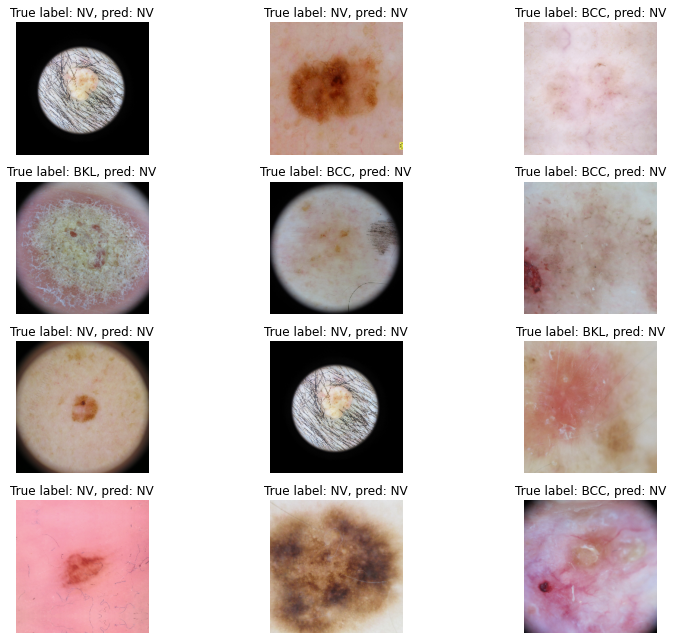

In [23]:
plot(num_images=12, model=model)